<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 340, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 340 (delta 89), reused 165 (delta 36), pack-reused 80 (from 1)
Receiving objects: 100% (340/340), 233.08 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Updating files: 100% (56/56), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [35]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [36]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [37]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [38]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [39]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [40]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='avg_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [269]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_int("n_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [57]:
demandDF = test_df[['avg_30_min_demand']]

In [58]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [59]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1023 - mean_absolute_percentage_error: 280096.1562 - root_mean_squared_error: 0.3129 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 51.8121 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - mean_absolute_percentage_error: 1243151.6250 - root_mean_squared_error: 0.1463 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 35.1615 - val_root_mean_squared_error: 0.1137
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mean_absolute_percentage_error: 1113141.5000 - root_mean_squared_error: 0.1318 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 35.7324 - val_root_mean_squared_error: 0.1126
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0168 - mean_absolute_percentage_error: 1099899.2500 - root_mean_squared_error: 0.1296 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 36.2726 - val_root_mean_squared_error: 0.11

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


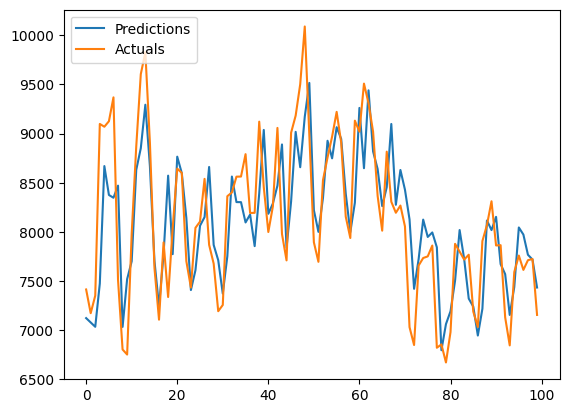

MAPE: 3.93%
RMSE: 426.69
MAE : 317.77


Predictions      Actuals
0    7121.205566  7412.811667
1    7076.860352  7171.183125
2    7032.746094  7350.264167
3    7472.768066  9098.258333
4    8669.404297  9070.002917
..           ...          ...
719  7914.141602  7374.332292
720  7875.063965  8039.583333
721  8215.772461  8575.767292
722  8446.066406  7909.507917
723  7633.836426  7144.386250

[724 rows x 2 columns]

In [61]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


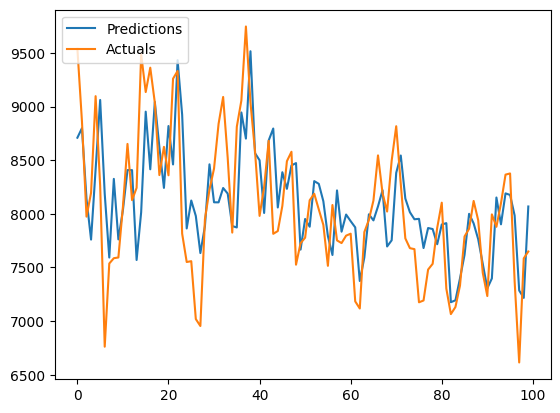

MAPE: 3.77%
RMSE: 390.23
MAE : 299.90


Predictions      Actuals
0    8709.195312  9537.097917
1    8797.901367  8863.333125
2    8139.708496  7973.787500
3    7759.859863  8194.981667
4    8414.903320  9096.434375
..           ...          ...
353  8012.542969  8447.030417
354  8187.910156  8771.408958
355  7979.823730  8487.014792
356  7552.437500  8380.489792
357  7651.709961  8437.980833

[358 rows x 2 columns]

In [62]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


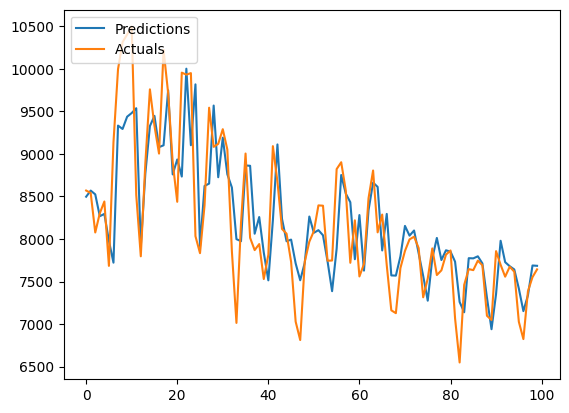

MAPE: 3.86%
RMSE: 411.04
MAE : 307.15


Predictions      Actuals
0    8497.058594  8569.568125
1    8569.014648  8540.904167
2    8524.477539  8076.513125
3    8267.698242  8302.971875
4    8294.909180  8440.820000
..           ...          ...
353  7673.061523  7508.199792
354  7796.646484  7694.271458
355  7478.442383  7746.240833
356  7602.429199  8321.401042
357  7879.885742  8503.726875

[358 rows x 2 columns]

In [63]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 - Overlapping Windows ###

In [64]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [65]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1478 - root_mean_squared_error: 0.3830 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - root_mean_squared_error: 0.1659 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


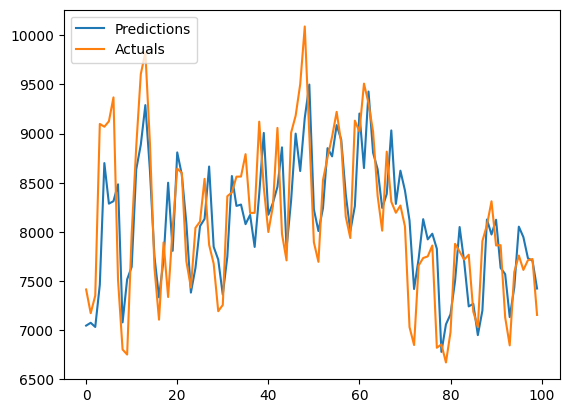

MAPE: 3.93%
RMSE: 429.10
MAE : 318.67


Predictions      Actuals
0    7044.924316  7412.811667
1    7073.548340  7171.183125
2    7031.095703  7350.264167
3    7460.373535  9098.258333
4    8699.734375  9070.002917
..           ...          ...
719  7921.874512  7374.332292
720  7883.685059  8039.583333
721  8209.702148  8575.767292
722  8428.221680  7909.507917
723  7584.022461  7144.386250

[724 rows x 2 columns]

In [67]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


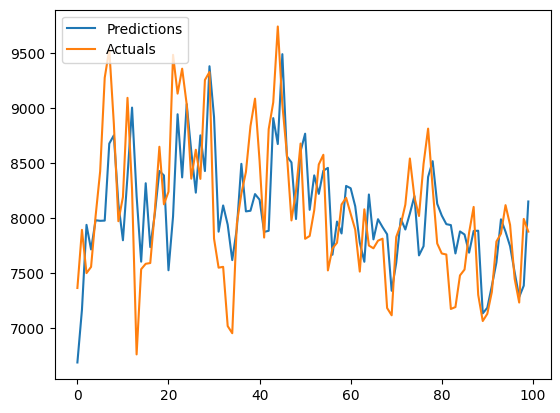

MAPE: 3.84%
RMSE: 399.82
MAE : 305.97


Predictions      Actuals
0    6688.207031  7365.989375
1    7167.237793  7895.121667
2    7940.584473  7501.373542
3    7716.875000  7557.751458
4    7982.480469  8021.308125
..           ...          ...
360  8048.801270  8447.030417
361  8137.955566  8771.408958
362  7636.902832  8487.014792
363  7554.447754  8380.489792
364  7666.005371  8437.980833

[365 rows x 2 columns]

In [68]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


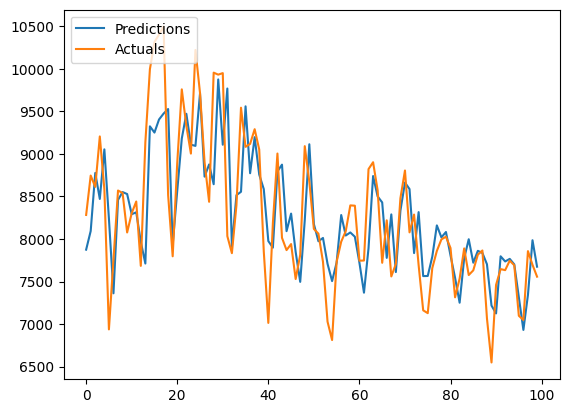

MAPE: 3.94%
RMSE: 419.25
MAE : 313.84


Predictions      Actuals
0    7874.767090  8282.850208
1    8093.984375  8745.688125
2    8776.194336  8612.550625
3    8470.849609  9205.374583
4    9053.514648  8584.935417
..           ...          ...
360  7696.954590  7508.199792
361  7805.738770  7694.271458
362  7438.770508  7746.240833
363  7583.280762  8321.401042
364  7883.747070  8503.726875

[365 rows x 2 columns]

In [69]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [70]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]

In [71]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [77]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1689 - root_mean_squared_error: 0.3985 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0187 - root_mean_squared_error: 0.1366 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


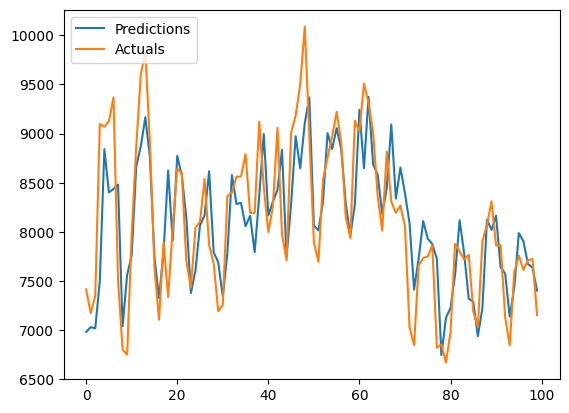

MAPE: 3.87%
RMSE: 422.60
MAE : 312.11


Predictions      Actuals
0    6981.075195  7412.811667
1    7029.276855  7171.183125
2    7016.482910  7350.264167
3    7498.585938  9098.258333
4    8841.576172  9070.002917
..           ...          ...
719  7948.691895  7374.332292
720  7972.105957  8039.583333
721  8342.347656  8575.767292
722  8537.384766  7909.507917
723  7671.515625  7144.386250

[724 rows x 2 columns]

In [79]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


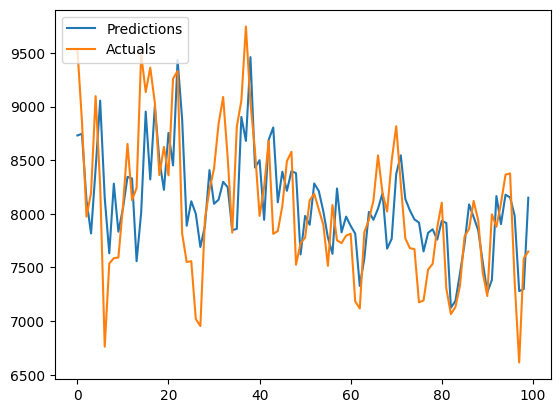

MAPE: 3.74%
RMSE: 386.29
MAE : 297.24


Predictions      Actuals
0    8730.295898  9537.097917
1    8745.643555  8863.333125
2    8123.471191  7973.787500
3    7817.028320  8194.981667
4    8419.733398  9096.434375
..           ...          ...
353  8027.223633  8447.030417
354  8352.986328  8771.408958
355  8182.853516  8487.014792
356  7807.722168  8380.489792
357  7807.719238  8437.980833

[358 rows x 2 columns]

In [80]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


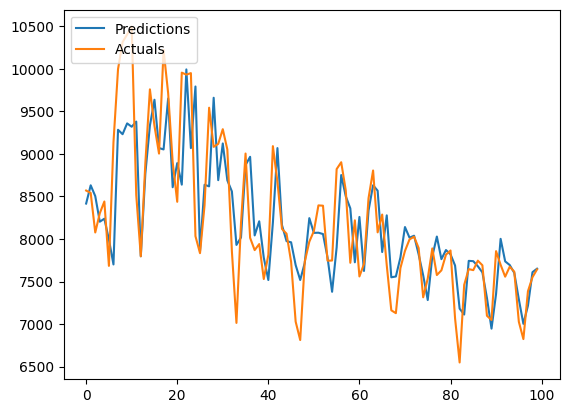

MAPE: 3.90%
RMSE: 418.61
MAE : 309.65


Predictions      Actuals
0    8416.632812  8569.568125
1    8631.010742  8540.904167
2    8503.884766  8076.513125
3    8203.336914  8302.971875
4    8238.591797  8440.820000
..           ...          ...
353  7716.901855  7508.199792
354  7925.281250  7694.271458
355  7763.729492  7746.240833
356  7839.935059  8321.401042
357  8109.726074  8503.726875

[358 rows x 2 columns]

In [81]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

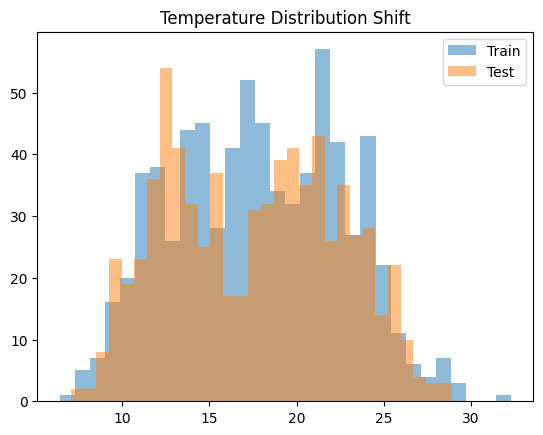

In [82]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [83]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [84]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [88]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1445 - root_mean_squared_error: 0.3688 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - root_mean_squared_error: 0.1562 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


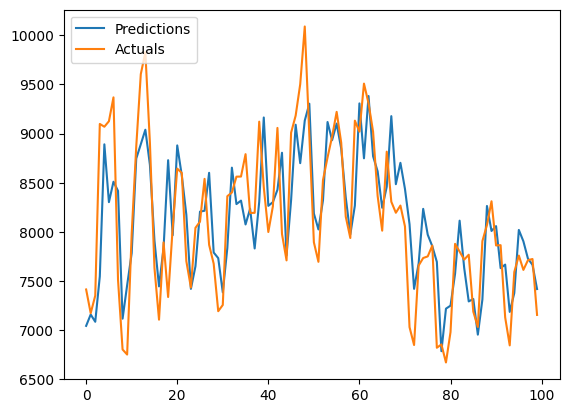

MAPE: 4.01%
RMSE: 428.19
MAE : 321.33


Predictions      Actuals
0    7042.152832  7412.811667
1    7157.894043  7171.183125
2    7083.876465  7350.264167
3    7546.327637  9098.258333
4    8890.700195  9070.002917
..           ...          ...
719  7879.492188  7374.332292
720  8109.453613  8039.583333
721  8293.932617  8575.767292
722  8283.535156  7909.507917
723  7402.633301  7144.386250

[724 rows x 2 columns]

In [90]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


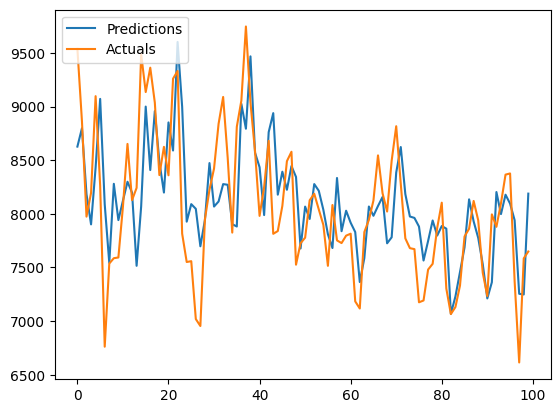

MAPE: 3.88%
RMSE: 395.90
MAE : 306.71


Predictions      Actuals
0    8626.308594  9537.097917
1    8797.329102  8863.333125
2    8182.682617  7973.787500
3    7901.592285  8194.981667
4    8432.061523  9096.434375
..           ...          ...
353  7995.980469  8447.030417
354  8286.573242  8771.408958
355  8073.837402  8487.014792
356  7757.753418  8380.489792
357  7820.179199  8437.980833

[358 rows x 2 columns]

In [91]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


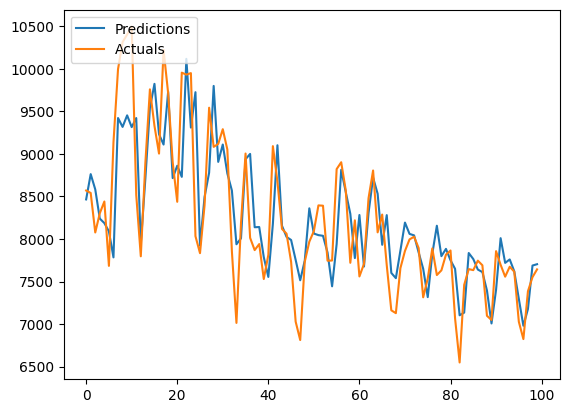

MAPE: 4.05%
RMSE: 421.83
MAE : 320.07


Predictions      Actuals
0    8465.220703  8569.568125
1    8762.481445  8540.904167
2    8583.250977  8076.513125
3    8239.577148  8302.971875
4    8186.848145  8440.820000
..           ...          ...
353  7724.206055  7508.199792
354  7842.919922  7694.271458
355  7691.909180  7746.240833
356  7675.483398  8321.401042
357  7982.004395  8503.726875

[358 rows x 2 columns]

In [92]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

## Model 5 ##

In [93]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [94]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [95]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0536 - root_mean_squared_error: 0.2281 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0228 - root_mean_squared_error: 0.1508 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1281 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


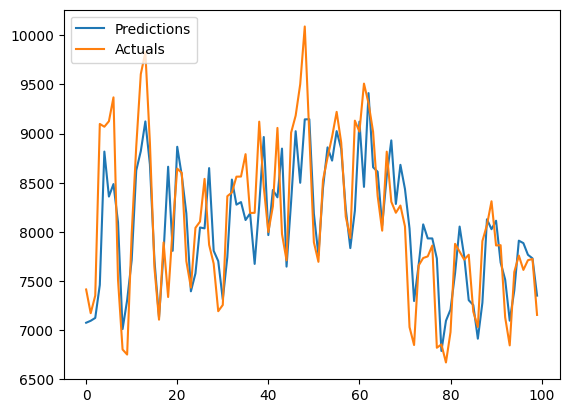

MAPE: 3.72%
RMSE: 408.56
MAE : 301.59


Predictions      Actuals
0    7074.036621  7412.811667
1    7094.041016  7171.183125
2    7123.074219  7350.264167
3    7458.989258  9098.258333
4    8816.880859  9070.002917
..           ...          ...
719  7883.471191  7374.332292
720  7967.837402  8039.583333
721  8318.997070  8575.767292
722  8481.326172  7909.507917
723  7650.277344  7144.386250

[724 rows x 2 columns]

In [97]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


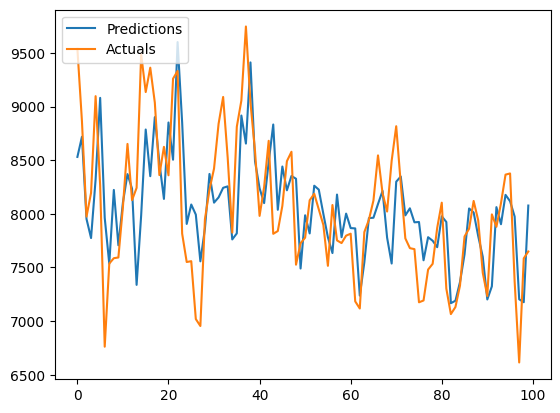

MAPE: 3.72%
RMSE: 387.73
MAE : 296.14


Predictions      Actuals
0    8530.305664  9537.097917
1    8717.743164  8863.333125
2    7952.204102  7973.787500
3    7774.277344  8194.981667
4    8320.962891  9096.434375
..           ...          ...
353  7998.523438  8447.030417
354  8267.683594  8771.408958
355  8037.898438  8487.014792
356  7602.946289  8380.489792
357  7568.274902  8437.980833

[358 rows x 2 columns]

In [98]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


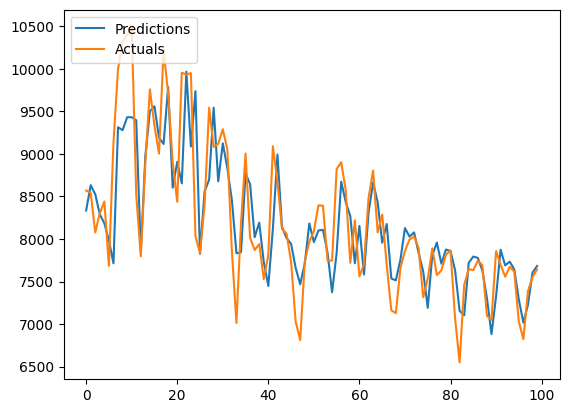

MAPE: 3.78%
RMSE: 403.86
MAE : 300.94


Predictions      Actuals
0    8335.500977  8569.568125
1    8632.379883  8540.904167
2    8526.234375  8076.513125
3    8290.673828  8302.971875
4    8183.627930  8440.820000
..           ...          ...
353  7694.856445  7508.199792
354  7860.929199  7694.271458
355  7700.629883  7746.240833
356  7812.840332  8321.401042
357  8036.939453  8503.726875

[358 rows x 2 columns]

In [99]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [100]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [101]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [102]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0857 - root_mean_squared_error: 0.2850 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1320 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


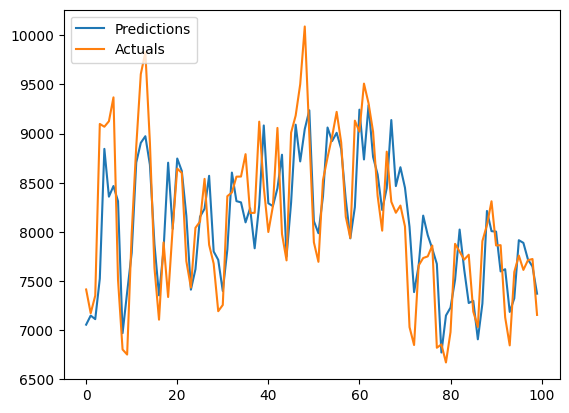

MAPE: 3.91%
RMSE: 421.83
MAE : 314.62


Predictions      Actuals
0    7054.526367  7412.811667
1    7146.918945  7171.183125
2    7110.578125  7350.264167
3    7523.251465  9098.258333
4    8844.570312  9070.002917
..           ...          ...
719  7844.475098  7374.332292
720  8065.215332  8039.583333
721  8211.720703  8575.767292
722  8248.745117  7909.507917
723  7360.563477  7144.386250

[724 rows x 2 columns]

In [104]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


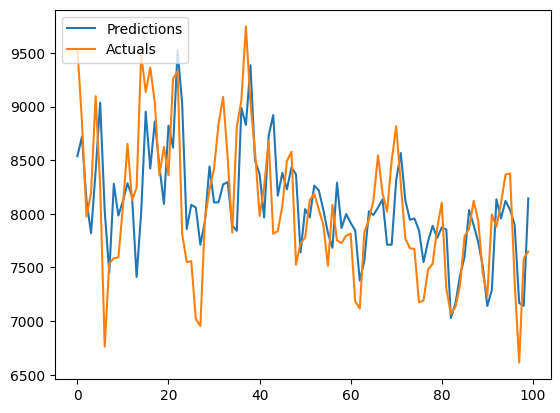

MAPE: 3.85%
RMSE: 395.22
MAE : 305.29


Predictions      Actuals
0    8536.576172  9537.097917
1    8718.479492  8863.333125
2    8122.297852  7973.787500
3    7819.353027  8194.981667
4    8394.750000  9096.434375
..           ...          ...
353  7912.833008  8447.030417
354  8253.150391  8771.408958
355  8103.975098  8487.014792
356  7691.968750  8380.489792
357  7678.890137  8437.980833

[358 rows x 2 columns]

In [105]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


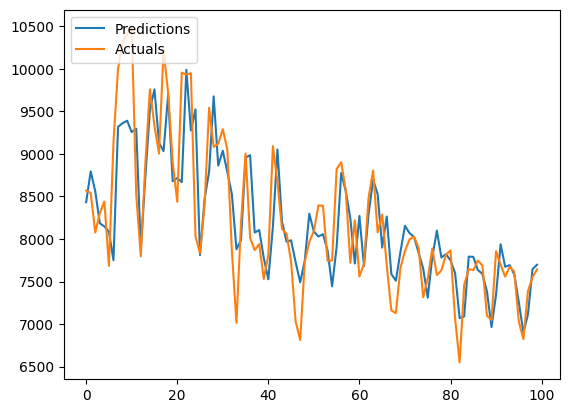

MAPE: 3.94%
RMSE: 414.72
MAE : 312.70


Predictions      Actuals
0    8432.294922  8569.568125
1    8795.134766  8540.904167
2    8560.975586  8076.513125
3    8185.089844  8302.971875
4    8147.104980  8440.820000
..           ...          ...
353  7617.820801  7508.199792
354  7779.810059  7694.271458
355  7652.025391  7746.240833
356  7648.271973  8321.401042
357  7962.062500  8503.726875

[358 rows x 2 columns]

In [106]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [107]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [110]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0717 - root_mean_squared_error: 0.2631 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0234 - root_mean_squared_error: 0.1527 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - root_mean_squared_error: 0.1376 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1305 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


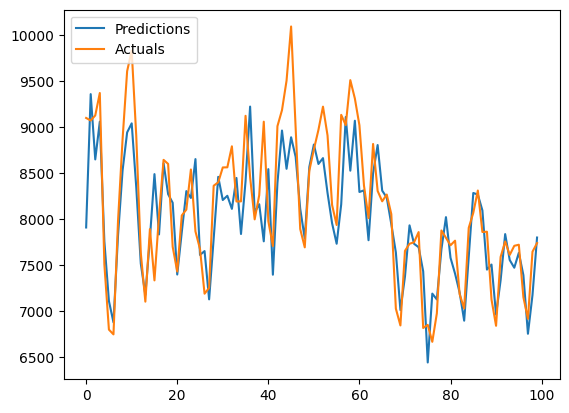

MAPE: 3.61%
RMSE: 397.32
MAE : 295.18


Predictions      Actuals
0    7909.987793  9098.258333
1    9356.822266  9070.002917
2    8648.493164  9125.678750
3    9058.445312  9368.951875
4    7760.077148  7510.325833
..           ...          ...
716  7045.759766  7374.332292
717  7404.365723  8039.583333
718  7912.622070  8575.767292
719  8276.901367  7909.507917
720  7230.568848  7144.386250

[721 rows x 2 columns]

In [112]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


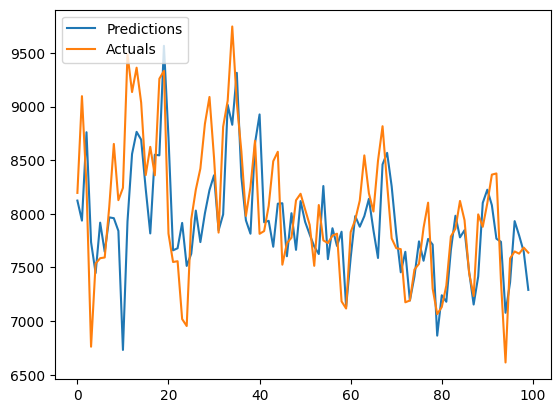

MAPE: 3.63%
RMSE: 385.17
MAE : 292.74


Predictions      Actuals
0    8123.327148  8194.981667
1    7936.735352  9096.434375
2    8760.193359  8261.405417
3    7736.010742  6761.608125
4    7448.298828  7536.762292
..           ...          ...
350  7828.717285  8447.030417
351  8090.154297  8771.408958
352  8140.023926  8487.014792
353  7707.712891  8380.489792
354  7693.464355  8437.980833

[355 rows x 2 columns]

In [113]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


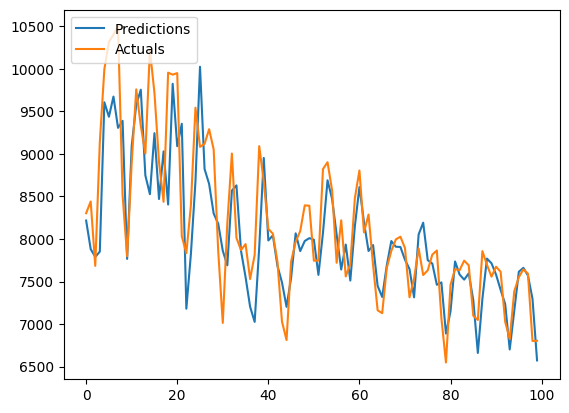

MAPE: 3.84%
RMSE: 411.86
MAE : 309.32


Predictions      Actuals
0    8217.043945  8302.971875
1    7881.571289  8440.820000
2    7789.499023  7684.176042
3    7851.768066  9135.772083
4    9607.054688  9995.508542
..           ...          ...
350  7495.759277  7508.199792
351  7622.477539  7694.271458
352  7736.430176  7746.240833
353  7723.776855  8321.401042
354  8244.130859  8503.726875

[355 rows x 2 columns]

In [114]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

## Model 8 - Decrease Window Size to 5 ##

In [115]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [116]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0434 - root_mean_squared_error: 0.2071 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1329
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1327 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - root_mean_squared_error: 0.1289 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


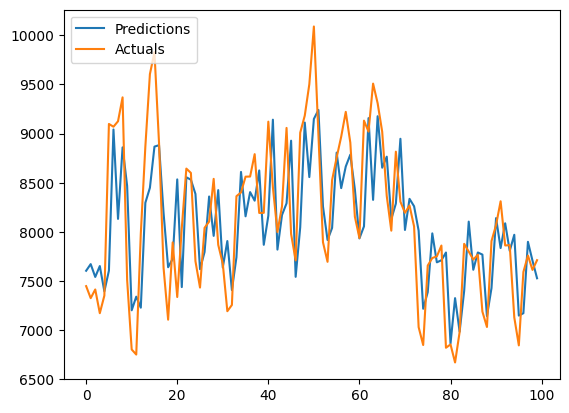

MAPE: 4.33%
RMSE: 460.98
MAE : 348.75


Predictions      Actuals
0    7603.372559  7446.897083
1    7671.006348  7324.388958
2    7540.353516  7412.811667
3    7651.267090  7171.183125
4    7393.705078  7350.264167
..           ...          ...
721  7397.989258  7374.332292
722  7798.511230  8039.583333
723  8085.305664  8575.767292
724  8374.383789  7909.507917
725  7481.858887  7144.386250

[726 rows x 2 columns]

In [118]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


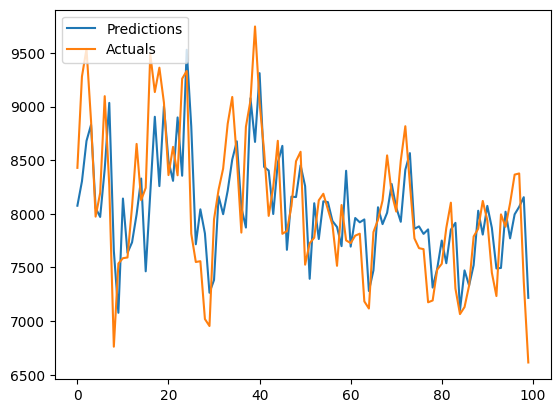

MAPE: 4.02%
RMSE: 405.52
MAE : 319.79


Predictions      Actuals
0    8075.465332  8428.290208
1    8302.697266  9279.195417
2    8679.469727  9537.097917
3    8829.391602  8863.333125
4    8054.799805  7973.787500
..           ...          ...
355  7693.535156  8447.030417
356  8257.321289  8771.408958
357  8214.826172  8487.014792
358  7985.552734  8380.489792
359  8106.655273  8437.980833

[360 rows x 2 columns]

In [119]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


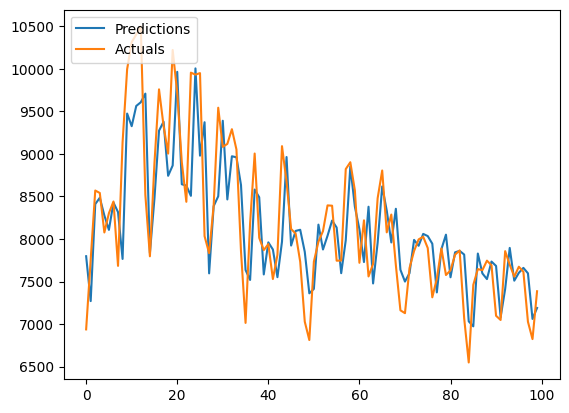

MAPE: 4.21%
RMSE: 434.57
MAE : 332.82


Predictions      Actuals
0    7797.618652  6937.700208
1    7270.236328  7759.521667
2    8410.069336  8569.568125
3    8484.537109  8540.904167
4    8276.487305  8076.513125
..           ...          ...
355  7611.520508  7508.199792
356  7802.097656  7694.271458
357  7762.806152  7746.240833
358  7801.169922  8321.401042
359  8289.408203  8503.726875

[360 rows x 2 columns]

In [120]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [121]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [122]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0502 - root_mean_squared_error: 0.2224 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1226
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186 - root_mean_squared_error: 0.1362 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


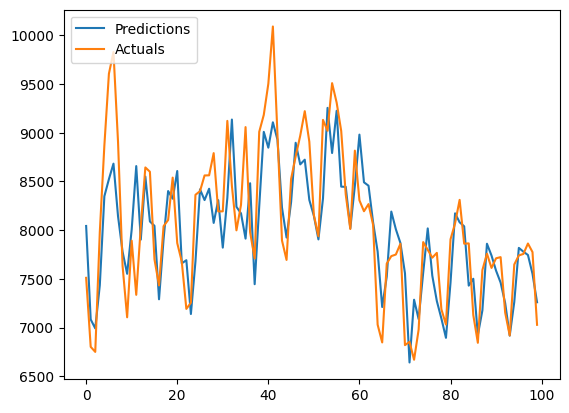

MAPE: 3.75%
RMSE: 410.76
MAE : 305.53


Predictions      Actuals
0    8042.832520  7510.325833
1    7083.393555  6801.918750
2    6991.485352  6750.140625
3    7434.828125  7981.096667
4    8347.799805  8868.038333
..           ...          ...
712  7494.169922  7374.332292
713  7715.476074  8039.583333
714  7912.181641  8575.767292
715  7970.060059  7909.507917
716  7311.358887  7144.386250

[717 rows x 2 columns]

In [124]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


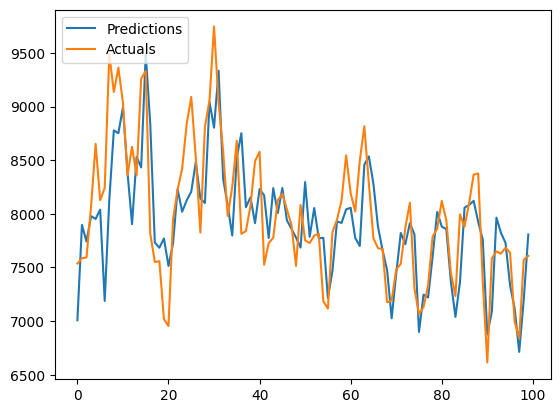

MAPE: 3.56%
RMSE: 369.13
MAE : 284.83


Predictions      Actuals
0    7008.074707  7536.762292
1    7895.877441  7586.311250
2    7742.240234  7593.115208
3    7978.662109  8067.645208
4    7952.284668  8651.321042
..           ...          ...
346  7708.803223  8447.030417
347  8007.666992  8771.408958
348  8020.090820  8487.014792
349  7652.099609  8380.489792
350  7857.515625  8437.980833

[351 rows x 2 columns]

In [125]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


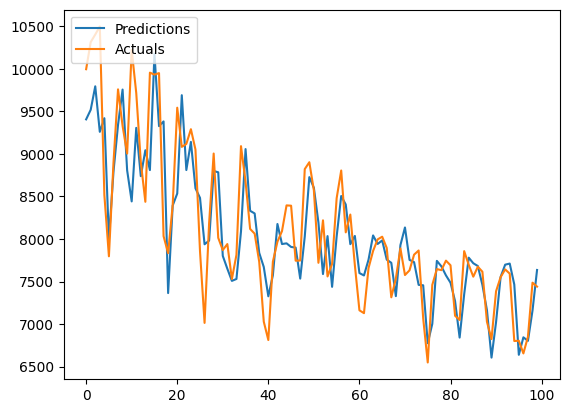

MAPE: 3.92%
RMSE: 406.92
MAE : 312.66


Predictions       Actuals
0    9405.981445   9995.508542
1    9518.463867  10313.686458
2    9794.337891  10402.964375
3    9259.310547  10497.618958
4    9419.856445   8517.349375
..           ...           ...
346  7303.740723   7508.199792
347  7394.723633   7694.271458
348  7655.102051   7746.240833
349  7641.189453   8321.401042
350  8129.118164   8503.726875

[351 rows x 2 columns]

In [126]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [127]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [128]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [131]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0668 - root_mean_squared_error: 0.2535 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1287
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1332 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1147
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1252 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1134
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


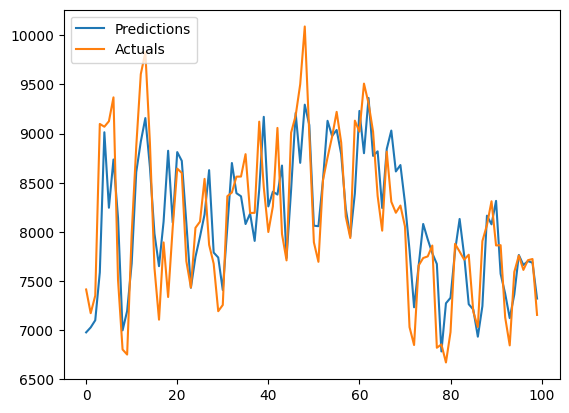

MAPE: 3.60%
RMSE: 395.17
MAE : 289.02


Predictions      Actuals
0    6975.977051  7412.811667
1    7026.495117  7171.183125
2    7099.127930  7350.264167
3    7586.867676  9098.258333
4    9013.667969  9070.002917
..           ...          ...
719  7974.802246  7374.332292
720  8143.121582  8039.583333
721  8230.665039  8575.767292
722  8254.092773  7909.507917
723  7372.654297  7144.386250

[724 rows x 2 columns]

In [133]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


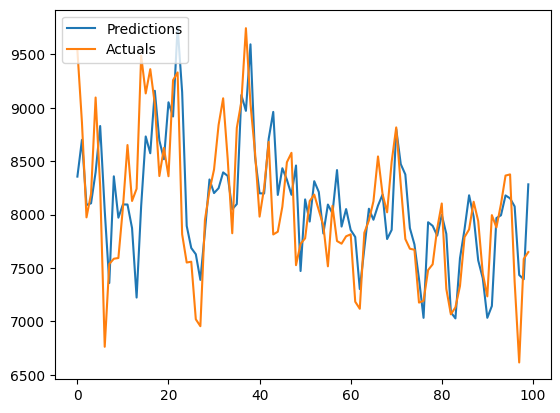

MAPE: 3.65%
RMSE: 381.51
MAE : 289.32


Predictions      Actuals
0    8355.526367  9537.097917
1    8700.128906  8863.333125
2    8088.837891  7973.787500
3    8105.674316  8194.981667
4    8396.603516  9096.434375
..           ...          ...
353  7960.837402  8447.030417
354  8228.250000  8771.408958
355  8341.878906  8487.014792
356  7879.391113  8380.489792
357  7817.378906  8437.980833

[358 rows x 2 columns]

In [134]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


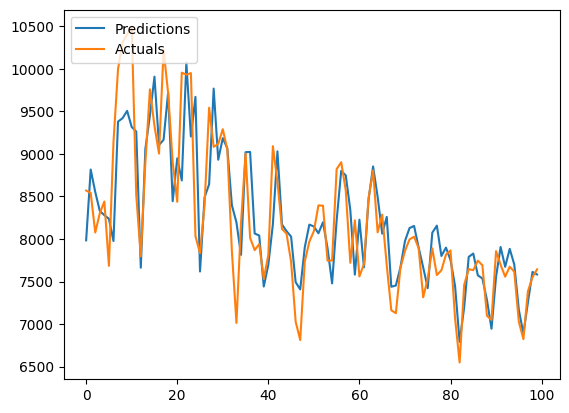

MAPE: 3.92%
RMSE: 412.66
MAE : 310.68


Predictions      Actuals
0    7984.226562  8569.568125
1    8816.448242  8540.904167
2    8552.486328  8076.513125
3    8329.228516  8302.971875
4    8280.081055  8440.820000
..           ...          ...
353  7858.817383  7508.199792
354  7848.112305  7694.271458
355  7948.994141  7746.240833
356  7868.932617  8321.401042
357  7880.985840  8503.726875

[358 rows x 2 columns]

In [135]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [136]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [137]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [138]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0917 - root_mean_squared_error: 0.2939 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1278 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1274 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


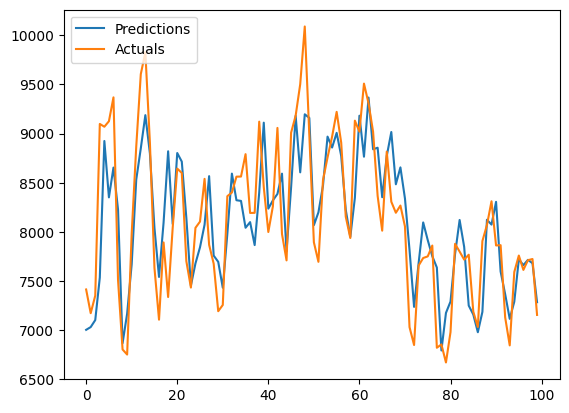

MAPE: 3.52%
RMSE: 390.53
MAE : 282.87


Predictions      Actuals
0    7001.900879  7412.811667
1    7029.874512  7171.183125
2    7101.116211  7350.264167
3    7534.173340  9098.258333
4    8924.705078  9070.002917
..           ...          ...
719  8080.836914  7374.332292
720  8147.112305  8039.583333
721  8290.746094  8575.767292
722  8224.657227  7909.507917
723  7507.631348  7144.386250

[724 rows x 2 columns]

In [140]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


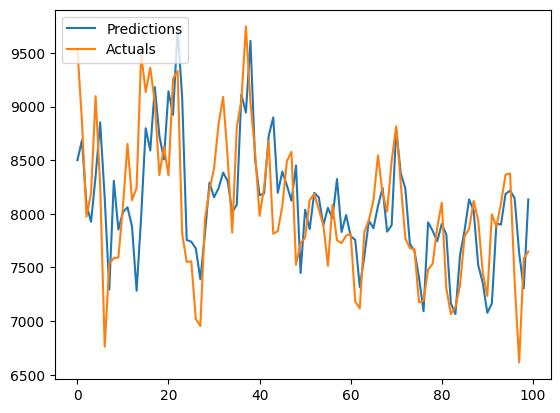

MAPE: 3.56%
RMSE: 375.32
MAE : 282.19


Predictions      Actuals
0    8499.335938  9537.097917
1    8685.580078  8863.333125
2    8083.049805  7973.787500
3    7925.012207  8194.981667
4    8351.951172  9096.434375
..           ...          ...
353  7963.072266  8447.030417
354  8268.581055  8771.408958
355  8269.989258  8487.014792
356  7872.410156  8380.489792
357  7768.431641  8437.980833

[358 rows x 2 columns]

In [141]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


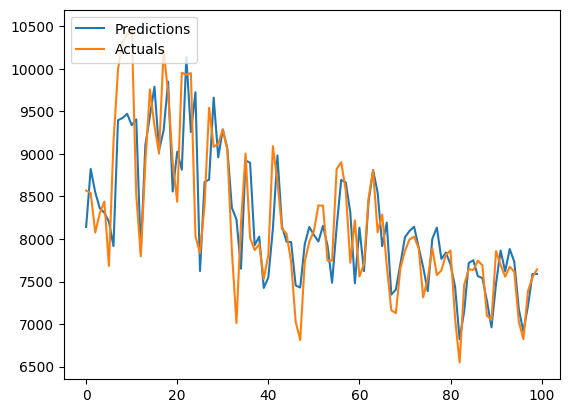

MAPE: 3.93%
RMSE: 413.90
MAE : 312.01


Predictions      Actuals
0    8141.925293  8569.568125
1    8823.000000  8540.904167
2    8548.005859  8076.513125
3    8360.105469  8302.971875
4    8309.215820  8440.820000
..           ...          ...
353  7929.112305  7508.199792
354  7957.853516  7694.271458
355  7921.439941  7746.240833
356  7788.562500  8321.401042
357  7718.104980  8503.726875

[358 rows x 2 columns]

In [142]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [143]:
tempPrecipDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [144]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [145]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0350 - root_mean_squared_error: 0.1842 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - root_mean_squared_error: 0.1197 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


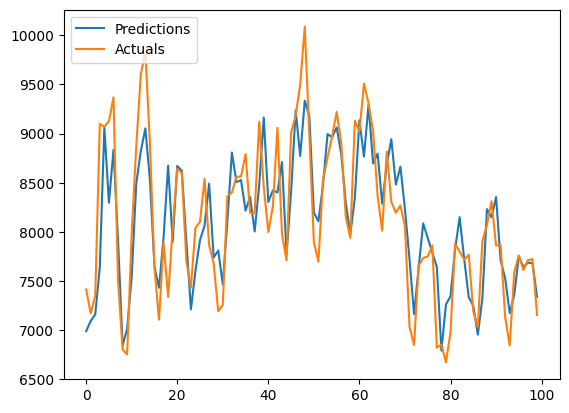

MAPE: 3.41%
RMSE: 374.84
MAE : 274.50


Predictions      Actuals
0    6988.150391  7412.811667
1    7090.884766  7171.183125
2    7158.907715  7350.264167
3    7640.040039  9098.258333
4    9060.498047  9070.002917
..           ...          ...
719  7943.797852  7374.332292
720  8203.012695  8039.583333
721  8224.537109  8575.767292
722  7927.203125  7909.507917
723  7293.036133  7144.386250

[724 rows x 2 columns]

In [148]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


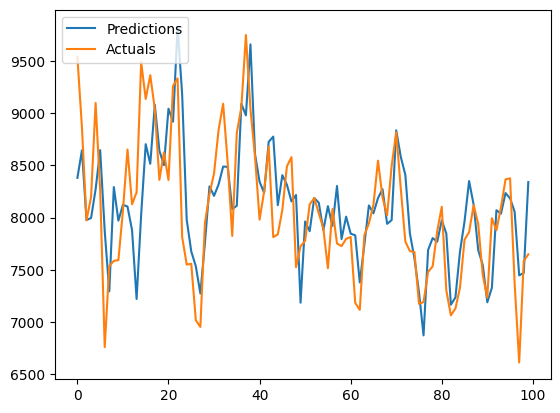

MAPE: 3.47%
RMSE: 365.79
MAE : 274.76


Predictions      Actuals
0    8379.932617  9537.097917
1    8643.732422  8863.333125
2    7977.092285  7973.787500
3    7996.136230  8194.981667
4    8270.099609  9096.434375
..           ...          ...
353  8056.888184  8447.030417
354  8387.694336  8771.408958
355  8429.666992  8487.014792
356  7966.241211  8380.489792
357  7888.276367  8437.980833

[358 rows x 2 columns]

In [149]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


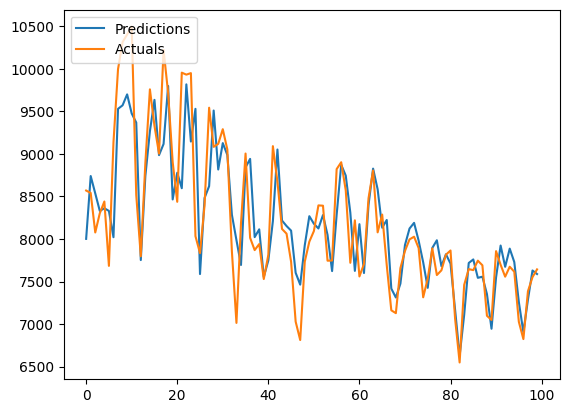

MAPE: 3.86%
RMSE: 401.61
MAE : 304.94


Predictions      Actuals
0    8001.671875  8569.568125
1    8739.830078  8540.904167
2    8535.978516  8076.513125
3    8329.640625  8302.971875
4    8361.274414  8440.820000
..           ...          ...
353  8031.533203  7508.199792
354  8070.765625  7694.271458
355  8141.628906  7746.240833
356  8038.046875  8321.401042
357  7968.653320  8503.726875

[358 rows x 2 columns]

In [150]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [151]:
tempSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [152]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [153]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1026 - root_mean_squared_error: 0.3100 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - root_mean_squared_error: 0.1391 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0160 - root_mean_squared_error: 0.1264 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1185
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1280 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - root_mean_squared_error: 0.1238 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


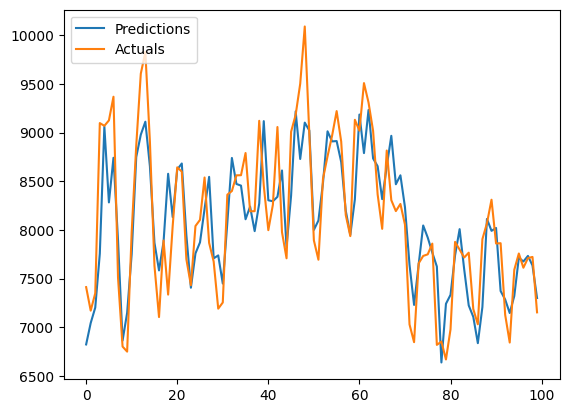

MAPE: 3.60%
RMSE: 390.52
MAE : 288.90


Predictions      Actuals
0    6823.961426  7412.811667
1    7044.035645  7171.183125
2    7202.334961  7350.264167
3    7756.202637  9098.258333
4    9062.199219  9070.002917
..           ...          ...
719  7829.745605  7374.332292
720  8154.083984  8039.583333
721  8096.194336  8575.767292
722  8086.090820  7909.507917
723  7406.664551  7144.386250

[724 rows x 2 columns]

In [155]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


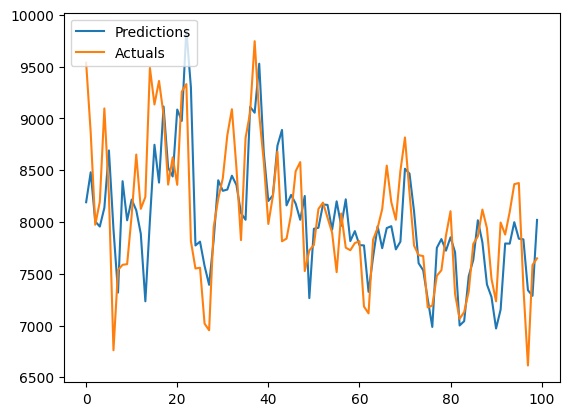

MAPE: 3.77%
RMSE: 390.77
MAE : 299.03


Predictions      Actuals
0    8190.771973  9537.097917
1    8479.799805  8863.333125
2    8005.235352  7973.787500
3    7955.904297  8194.981667
4    8136.837891  9096.434375
..           ...          ...
353  8147.467285  8447.030417
354  8424.696289  8771.408958
355  8380.456055  8487.014792
356  7942.209473  8380.489792
357  7822.357422  8437.980833

[358 rows x 2 columns]

In [156]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


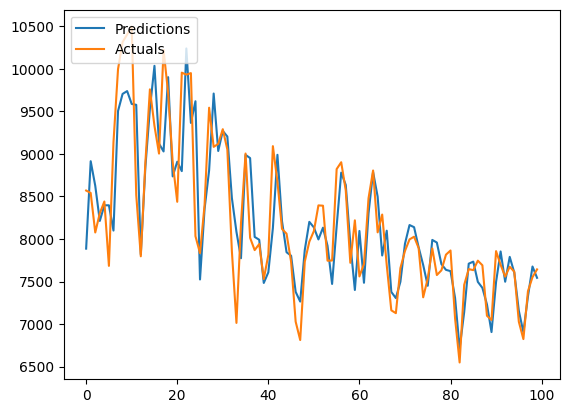

MAPE: 3.89%
RMSE: 406.29
MAE : 307.52


Predictions      Actuals
0    7886.701660  8569.568125
1    8914.251953  8540.904167
2    8625.364258  8076.513125
3    8212.417969  8302.971875
4    8396.159180  8440.820000
..           ...          ...
353  7858.870117  7508.199792
354  8019.542480  7694.271458
355  8039.653320  7746.240833
356  7867.425293  8321.401042
357  7842.224609  8503.726875

[358 rows x 2 columns]

In [157]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

## Model 14 - Precipitation and Sunlight ##

In [158]:
tempPreSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [159]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [160]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0885 - root_mean_squared_error: 0.2892 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - root_mean_squared_error: 0.1405 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1168
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1246 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


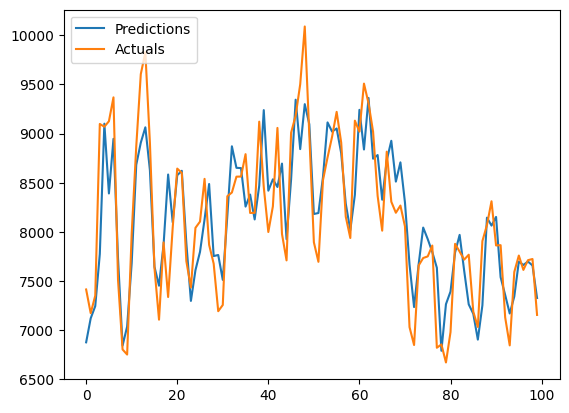

MAPE: 3.47%
RMSE: 371.44
MAE : 277.55


Predictions      Actuals
0    6874.662598  7412.811667
1    7118.995605  7171.183125
2    7243.257324  7350.264167
3    7774.098633  9098.258333
4    9101.042969  9070.002917
..           ...          ...
719  7840.414551  7374.332292
720  8196.556641  8039.583333
721  8248.925781  8575.767292
722  8047.954102  7909.507917
723  7414.074707  7144.386250

[724 rows x 2 columns]

In [162]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


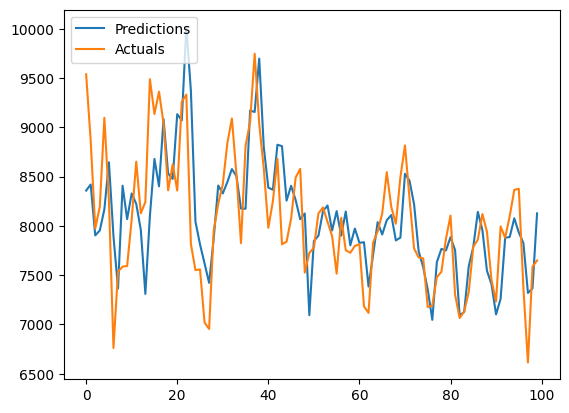

MAPE: 3.64%
RMSE: 380.55
MAE : 288.34


Predictions      Actuals
0    8358.197266  9537.097917
1    8419.425781  8863.333125
2    7903.659180  7973.787500
3    7953.469238  8194.981667
4    8167.328613  9096.434375
..           ...          ...
353  8325.151367  8447.030417
354  8651.517578  8771.408958
355  8705.216797  8487.014792
356  8280.375977  8380.489792
357  8107.262695  8437.980833

[358 rows x 2 columns]

In [163]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


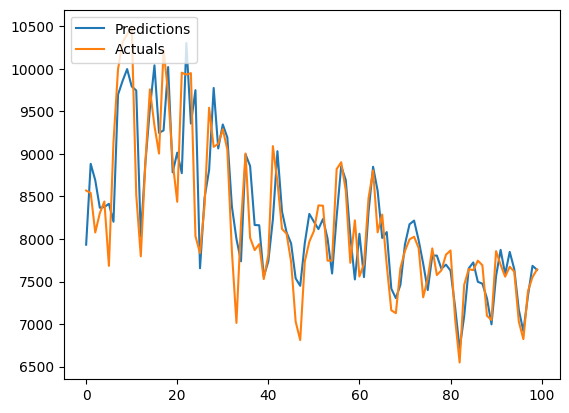

MAPE: 3.94%
RMSE: 405.98
MAE : 309.64


Predictions      Actuals
0    7933.179199  8569.568125
1    8883.296875  8540.904167
2    8690.791992  8076.513125
3    8367.101562  8302.971875
4    8376.544922  8440.820000
..           ...          ...
353  8112.252930  7508.199792
354  8246.788086  7694.271458
355  8286.646484  7746.240833
356  8104.417969  8321.401042
357  8101.099609  8503.726875

[358 rows x 2 columns]

In [164]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

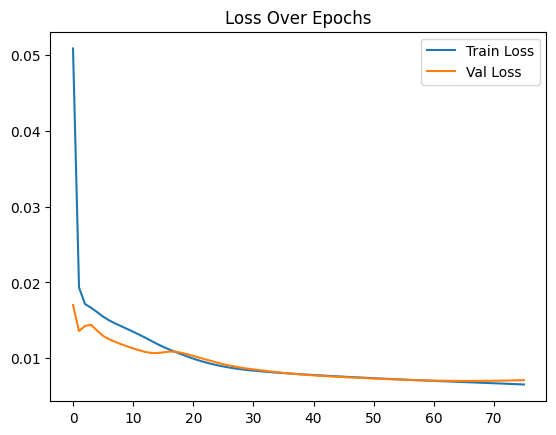

In [165]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [166]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [167]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [170]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1338 - root_mean_squared_error: 0.3546 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1181
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - root_mean_squared_error: 0.1293 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


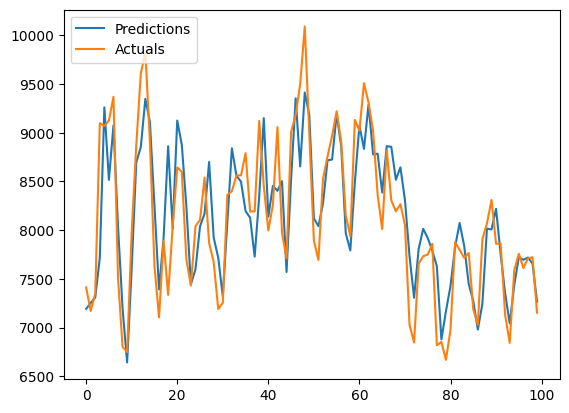

MAPE: 3.15%
RMSE: 348.83
MAE : 252.63


Predictions      Actuals
0    7192.871582  7412.811667
1    7253.524902  7171.183125
2    7310.004883  7350.264167
3    7717.768066  9098.258333
4    9260.458008  9070.002917
..           ...          ...
719  7979.505859  7374.332292
720  8398.601562  8039.583333
721  8417.867188  8575.767292
722  8058.833984  7909.507917
723  7142.512695  7144.386250

[724 rows x 2 columns]

In [172]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


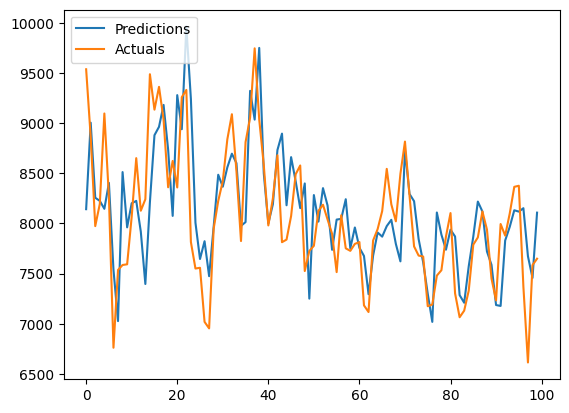

MAPE: 3.52%
RMSE: 376.74
MAE : 279.85


Predictions      Actuals
0    8142.547363  9537.097917
1    9004.904297  8863.333125
2    8256.470703  7973.787500
3    8225.250977  8194.981667
4    8146.239258  9096.434375
..           ...          ...
353  8152.643066  8447.030417
354  8695.620117  8771.408958
355  8468.027344  8487.014792
356  7789.799805  8380.489792
357  7471.169434  8437.980833

[358 rows x 2 columns]

In [173]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


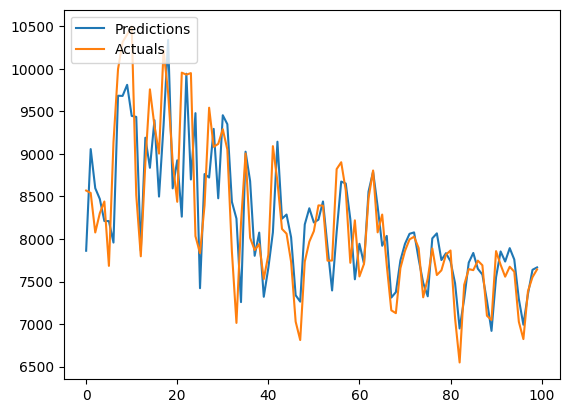

MAPE: 3.78%
RMSE: 407.26
MAE : 300.10


Predictions      Actuals
0    7862.008789  8569.568125
1    9056.761719  8540.904167
2    8597.460938  8076.513125
3    8470.510742  8302.971875
4    8211.182617  8440.820000
..           ...          ...
353  8076.015625  7508.199792
354  8212.550781  7694.271458
355  8209.370117  7746.240833
356  8029.059570  8321.401042
357  7710.131348  8503.726875

[358 rows x 2 columns]

In [174]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [175]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [176]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [177]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [178]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0287 - root_mean_squared_error: 0.1688 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - root_mean_squared_error: 0.1079 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - root_mean_squared_error: 0.1036 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1025
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


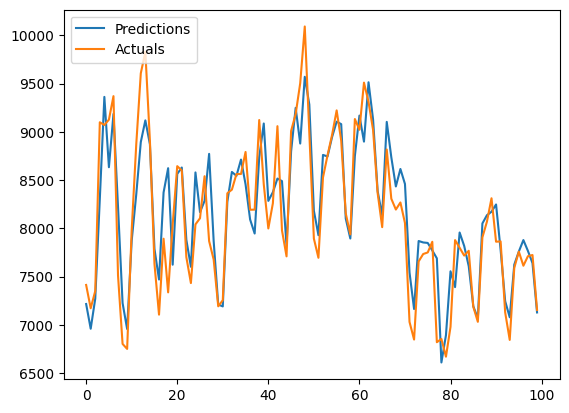

MAPE: 2.79%
RMSE: 313.19
MAE : 222.73


Predictions      Actuals
0    7215.270020  7412.811667
1    6959.330566  7171.183125
2    7270.969238  7350.264167
3    8302.215820  9098.258333
4    9361.259766  9070.002917
..           ...          ...
719  7279.946289  7374.332292
720  7812.570312  8039.583333
721  8062.866699  8575.767292
722  7824.124512  7909.507917
723  7282.858887  7144.386250

[724 rows x 2 columns]

In [179]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


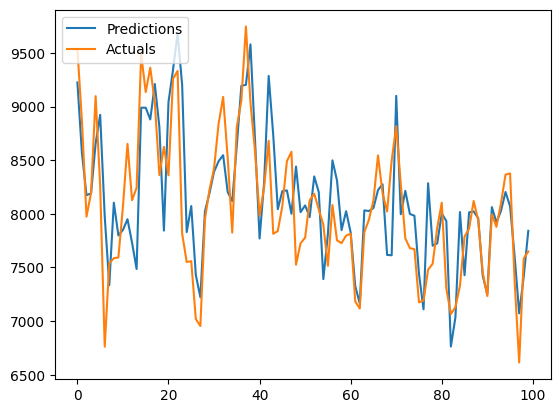

MAPE: 3.04%
RMSE: 330.48
MAE : 240.53


Predictions      Actuals
0    9223.909180  9537.097917
1    8565.123047  8863.333125
2    8173.832031  7973.787500
3    8190.243164  8194.981667
4    8655.436523  9096.434375
..           ...          ...
353  7615.136719  8447.030417
354  8103.673340  8771.408958
355  7797.650879  8487.014792
356  7738.259766  8380.489792
357  8427.542969  8437.980833

[358 rows x 2 columns]

In [180]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


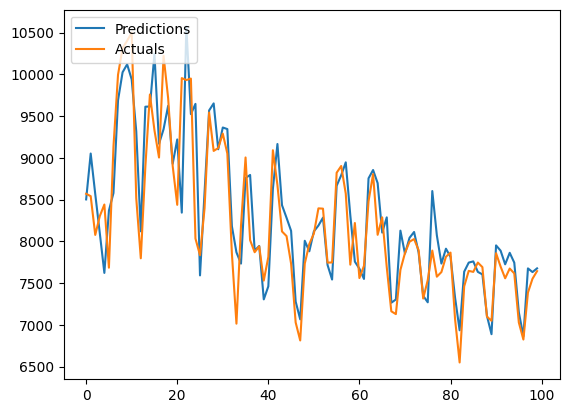

MAPE: 3.27%
RMSE: 351.91
MAE : 258.20


Predictions      Actuals
0    8502.212891  8569.568125
1    9051.643555  8540.904167
2    8565.981445  8076.513125
3    8097.358398  8302.971875
4    7621.677246  8440.820000
..           ...          ...
353  7246.977051  7508.199792
354  7032.138672  7694.271458
355  7710.663574  7746.240833
356  8500.515625  8321.401042
357  8374.809570  8503.726875

[358 rows x 2 columns]

In [181]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [182]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [183]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [184]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0460 - root_mean_squared_error: 0.2116 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1274 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0938
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095 - root_mean_squared_error: 0.0971 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


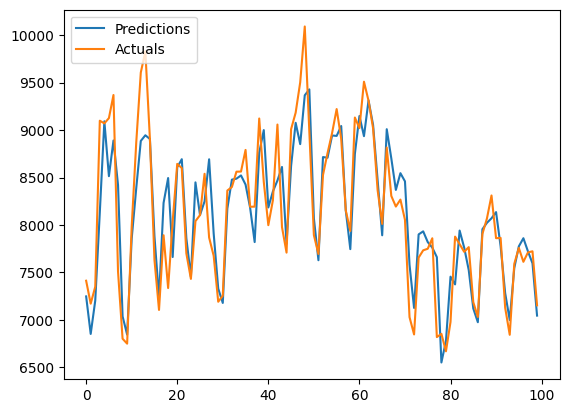

MAPE: 2.65%
RMSE: 311.05
MAE : 213.68


Predictions      Actuals
0    7247.747070  7412.811667
1    6852.571777  7171.183125
2    7203.729492  7350.264167
3    8133.429688  9098.258333
4    9092.116211  9070.002917
..           ...          ...
719  7290.490723  7374.332292
720  7879.317383  8039.583333
721  7960.140625  8575.767292
722  7902.204590  7909.507917
723  7291.215332  7144.386250

[724 rows x 2 columns]

In [186]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


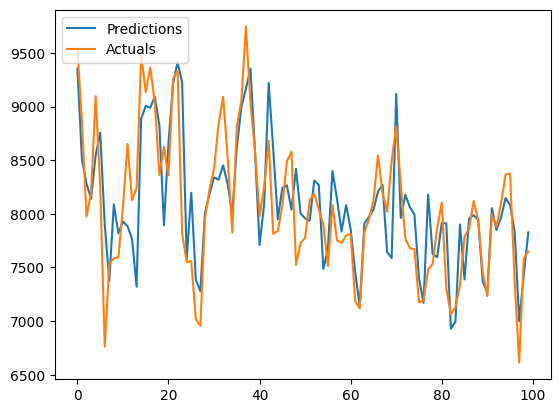

MAPE: 2.88%
RMSE: 318.24
MAE : 228.61


Predictions      Actuals
0    9354.678711  9537.097917
1    8506.632812  8863.333125
2    8279.251953  7973.787500
3    8141.192871  8194.981667
4    8542.749023  9096.434375
..           ...          ...
353  7570.807129  8447.030417
354  7950.507812  8771.408958
355  7847.955078  8487.014792
356  7595.722168  8380.489792
357  8680.647461  8437.980833

[358 rows x 2 columns]

In [187]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


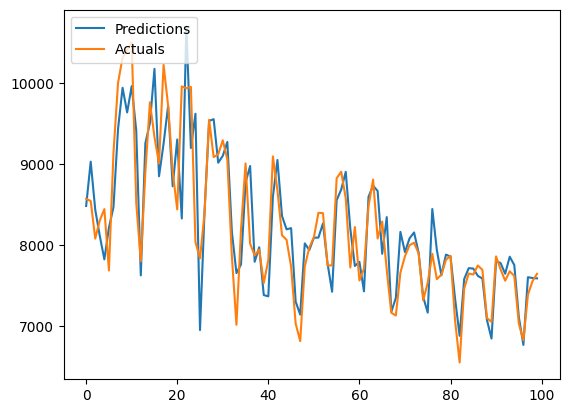

MAPE: 3.19%
RMSE: 353.37
MAE : 253.85


Predictions      Actuals
0    8479.597656  8569.568125
1    9026.136719  8540.904167
2    8432.021484  8076.513125
3    8109.092285  8302.971875
4    7820.989258  8440.820000
..           ...          ...
353  7275.078613  7508.199792
354  7037.355957  7694.271458
355  7409.238770  7746.240833
356  8385.585938  8321.401042
357  8148.394531  8503.726875

[358 rows x 2 columns]

In [188]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

## Month ##

In [189]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [190]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [191]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [192]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1231 - root_mean_squared_error: 0.3401 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1267
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1270 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


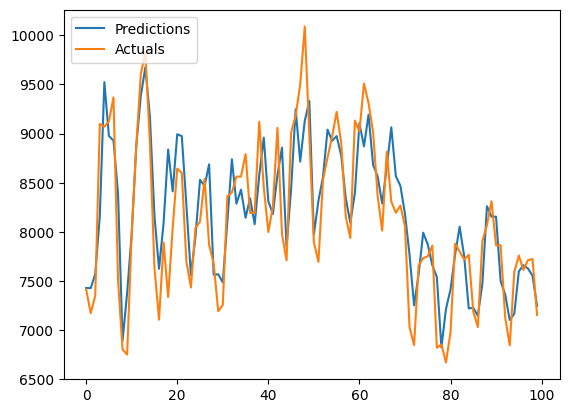

MAPE: 3.45%
RMSE: 371.53
MAE : 275.93


Predictions      Actuals
0    7428.069336  7412.811667
1    7426.291992  7171.183125
2    7570.521973  7350.264167
3    8161.715332  9098.258333
4    9523.863281  9070.002917
..           ...          ...
719  7951.463379  7374.332292
720  8304.771484  8039.583333
721  8351.527344  8575.767292
722  8273.179688  7909.507917
723  7552.961914  7144.386250

[724 rows x 2 columns]

In [193]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


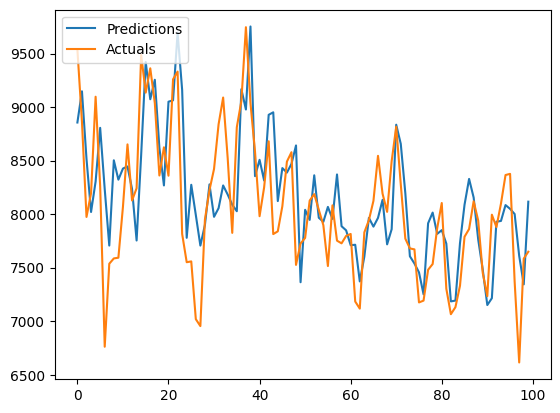

MAPE: 3.79%
RMSE: 388.33
MAE : 298.27


Predictions      Actuals
0    8855.642578  9537.097917
1    9147.046875  8863.333125
2    8515.665039  7973.787500
3    8020.083984  8194.981667
4    8304.474609  9096.434375
..           ...          ...
353  8050.263184  8447.030417
354  8386.303711  8771.408958
355  8414.958008  8487.014792
356  8037.126953  8380.489792
357  7886.273438  8437.980833

[358 rows x 2 columns]

In [194]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


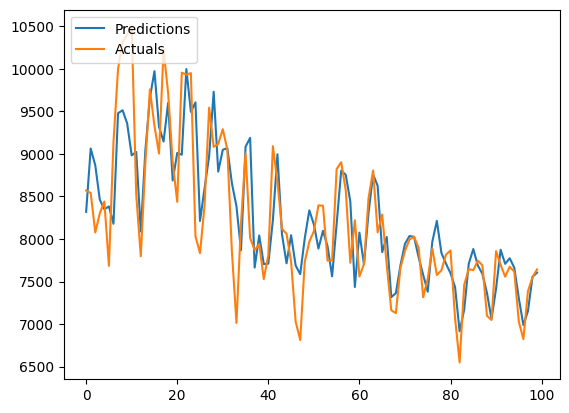

MAPE: 4.20%
RMSE: 431.09
MAE : 330.04


Predictions      Actuals
0    8318.991211  8569.568125
1    9063.244141  8540.904167
2    8866.941406  8076.513125
3    8462.100586  8302.971875
4    8348.807617  8440.820000
..           ...          ...
353  7943.848145  7508.199792
354  8083.368652  7694.271458
355  8055.270020  7746.240833
356  7946.416992  8321.401042
357  7999.252441  8503.726875

[358 rows x 2 columns]

In [195]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [196]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [197]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [198]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0886 - root_mean_squared_error: 0.2884 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - root_mean_squared_error: 0.1347 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


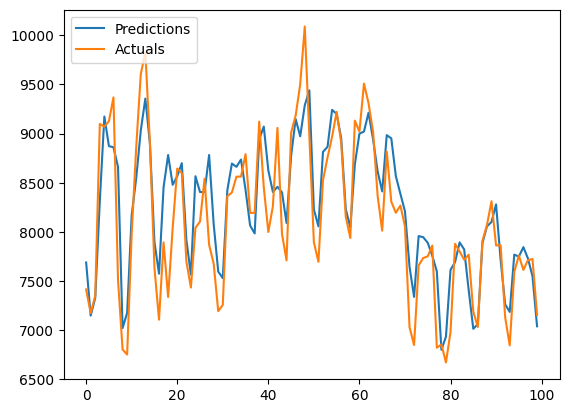

MAPE: 3.24%
RMSE: 373.08
MAE : 258.52


Predictions      Actuals
0    7687.900391  7412.811667
1    7147.046387  7171.183125
2    7327.642090  7350.264167
3    8313.202148  9098.258333
4    9173.869141  9070.002917
..           ...          ...
719  7849.898438  7374.332292
720  8152.173828  8039.583333
721  8147.751465  8575.767292
722  7921.572754  7909.507917
723  7556.426270  7144.386250

[724 rows x 2 columns]

In [200]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


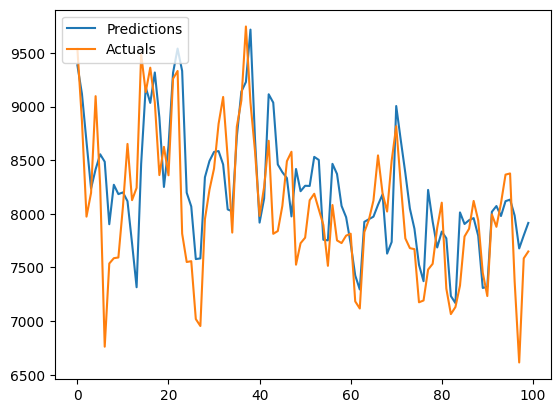

MAPE: 3.44%
RMSE: 372.25
MAE : 270.83


Predictions      Actuals
0    9384.680664  9537.097917
1    9117.627930  8863.333125
2    8671.607422  7973.787500
3    8236.074219  8194.981667
4    8414.944336  9096.434375
..           ...          ...
353  8108.842773  8447.030417
354  8051.294922  8771.408958
355  7847.349121  8487.014792
356  7559.985840  8380.489792
357  8547.105469  8437.980833

[358 rows x 2 columns]

In [201]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


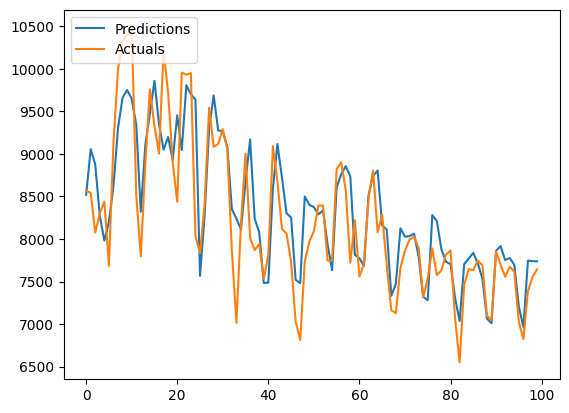

MAPE: 3.62%
RMSE: 395.20
MAE : 285.06


Predictions      Actuals
0    8518.411133  8569.568125
1    9056.448242  8540.904167
2    8874.244141  8076.513125
3    8269.885742  8302.971875
4    7981.923340  8440.820000
..           ...          ...
353  7854.207031  7508.199792
354  7384.832031  7694.271458
355  7400.875488  7746.240833
356  8275.509766  8321.401042
357  8537.913086  8503.726875

[358 rows x 2 columns]

In [202]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [245]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [246]:
model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0722 - root_mean_squared_error: 0.2599
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1164
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0991
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0941
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0929

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


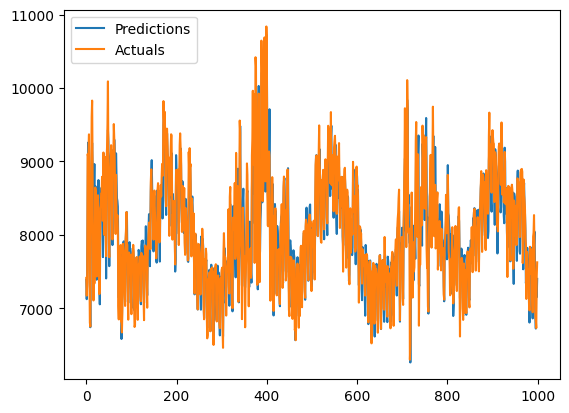

MAPE: 2.53%
RMSE: 288.10
MAE : 203.56


Predictions      Actuals
0     7387.155273  7412.811667
1     7122.742188  7171.183125
2     7313.949707  7350.264167
3     8216.033203  9098.258333
4     9255.950195  9070.002917
...           ...          ...
1084  7890.211914  8447.030417
1085  8582.630859  8771.408958
1086  8175.631836  8487.014792
1087  8034.471191  8380.489792
1088  8488.409180  8437.980833

[1089 rows x 2 columns]

In [248]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


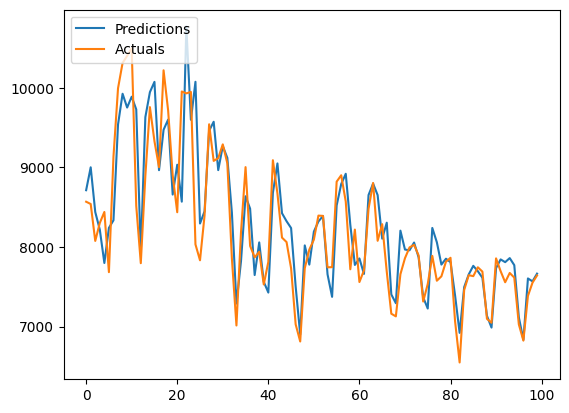

MAPE: 3.01%
RMSE: 340.69
MAE : 240.66


Predictions      Actuals
0    8714.298828  8569.568125
1    9001.995117  8540.904167
2    8439.855469  8076.513125
3    8218.290039  8302.971875
4    7799.433105  8440.820000
..           ...          ...
353  7429.234375  7508.199792
354  7421.038086  7694.271458
355  7903.611816  7746.240833
356  8439.345703  8321.401042
357  8059.423828  8503.726875

[358 rows x 2 columns]

In [249]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [250]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [251]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [252]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1160 - root_mean_squared_error: 0.3246
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0160 - root_mean_squared_error: 0.1267
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - root_mean_squared_error: 0.1190
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - root_mean_squared_error: 0.1135
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


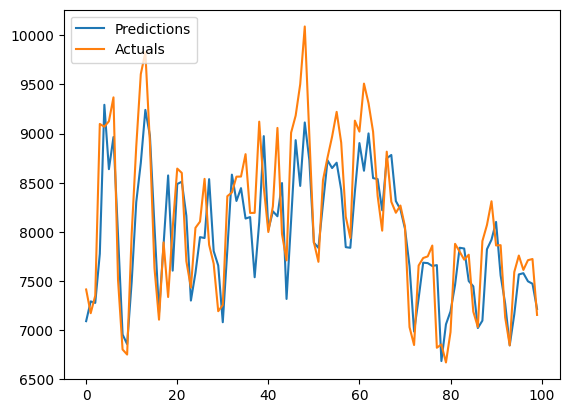

MAPE: 3.23%
RMSE: 361.29
MAE : 263.14


Predictions      Actuals
0     7090.222168  7412.811667
1     7291.325195  7171.183125
2     7275.997070  7350.264167
3     7775.751953  9098.258333
4     9293.352539  9070.002917
...           ...          ...
1084  8214.548828  8447.030417
1085  8628.861328  8771.408958
1086  8432.925781  8487.014792
1087  7855.884766  8380.489792
1088  7693.478516  8437.980833

[1089 rows x 2 columns]

In [253]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


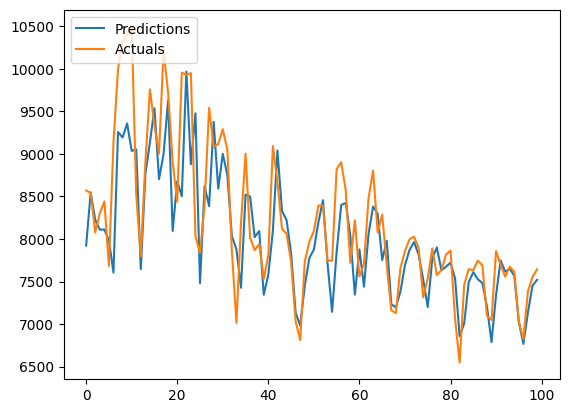

MAPE: 3.69%
RMSE: 405.35
MAE : 298.00


Predictions      Actuals
0    7922.356445  8569.568125
1    8547.831055  8540.904167
2    8223.297852  8076.513125
3    8110.107910  8302.971875
4    8111.291016  8440.820000
..           ...          ...
353  7875.306641  7508.199792
354  7907.496094  7694.271458
355  8049.422852  7746.240833
356  7856.597168  8321.401042
357  8003.204102  8503.726875

[358 rows x 2 columns]

In [254]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [255]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [256]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [257]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0944 - root_mean_squared_error: 0.2945
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - root_mean_squared_error: 0.1043
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


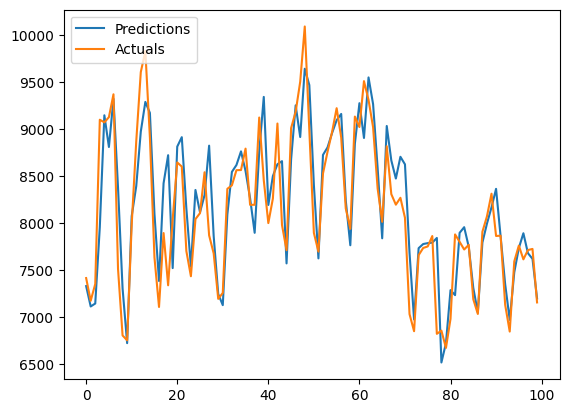

MAPE: 2.69%
RMSE: 301.25
MAE : 215.94


Predictions      Actuals
0     7327.537598  7412.811667
1     7110.595215  7171.183125
2     7141.949707  7350.264167
3     7956.155762  9098.258333
4     9145.454102  9070.002917
...           ...          ...
1084  7693.700684  8447.030417
1085  8462.147461  8771.408958
1086  8140.648438  8487.014792
1087  8047.811523  8380.489792
1088  8771.654297  8437.980833

[1089 rows x 2 columns]

In [258]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


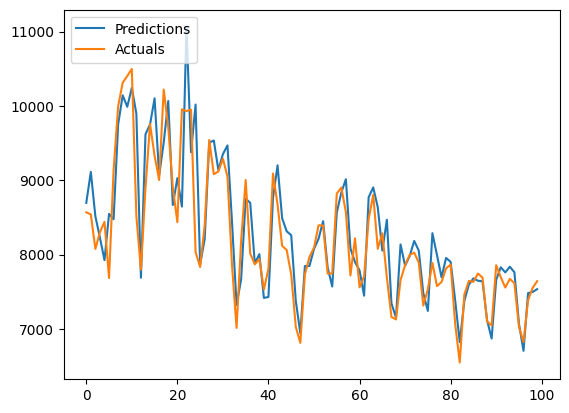

MAPE: 2.98%
RMSE: 341.34
MAE : 238.10


Predictions      Actuals
0    8695.941406  8569.568125
1    9112.473633  8540.904167
2    8515.000000  8076.513125
3    8227.564453  8302.971875
4    7926.041504  8440.820000
..           ...          ...
353  7373.833496  7508.199792
354  7327.274902  7694.271458
355  7907.158691  7746.240833
356  8502.855469  8321.401042
357  8201.861328  8503.726875

[358 rows x 2 columns]

In [259]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [261]:
!pip install Optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 34.8 MB/s eta 0:00:00


In [270]:
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=50)

[I 2025-09-17 15:01:04,150] A new study created in memory with name: no-name-9b94bff2-5472-46ac-81c7-14ee6d99c307
[I 2025-09-17 15:07:37,307] Trial 0 finished with value: 579.1318463033583 and parameters: {'n_units': 68, 'dropout': 0.4753571532049581, 'learning_rate': 0.0029106359131330704, 'batch_size': 1}. Best is trial 0 with value: 579.1318463033583.


Trial 0: units=68, dropout=0.48, lr=0.00291, batch=1, MAE=579.13, device=/GPU:0


[I 2025-09-17 15:08:39,928] Trial 1 finished with value: 437.5882419834598 and parameters: {'n_units': 116, 'dropout': 0.3005575058716044, 'learning_rate': 0.0026070247583707684, 'batch_size': 8}. Best is trial 1 with value: 437.5882419834598.


Trial 1: units=116, dropout=0.30, lr=0.00261, batch=8, MAE=437.59, device=/GPU:0


[I 2025-09-17 15:08:59,980] Trial 2 finished with value: 248.48015956557933 and parameters: {'n_units': 49, 'dropout': 0.09170225492671691, 'learning_rate': 0.0004059611610484307, 'batch_size': 32}. Best is trial 2 with value: 248.48015956557933.


Trial 2: units=49, dropout=0.09, lr=0.00041, batch=32, MAE=248.48, device=/GPU:0


[I 2025-09-17 15:10:00,864] Trial 3 finished with value: 282.93285479967074 and parameters: {'n_units': 45, 'dropout': 0.14607232426760908, 'learning_rate': 0.0005404103854647331, 'batch_size': 8}. Best is trial 2 with value: 248.48015956557933.


Trial 3: units=45, dropout=0.15, lr=0.00054, batch=8, MAE=282.93, device=/GPU:0


[I 2025-09-17 15:10:20,963] Trial 4 finished with value: 242.18828228888222 and parameters: {'n_units': 89, 'dropout': 0.023225206359998862, 'learning_rate': 0.0016409286730647919, 'batch_size': 32}. Best is trial 4 with value: 242.18828228888222.


Trial 4: units=89, dropout=0.02, lr=0.00164, batch=32, MAE=242.19, device=/GPU:0


[I 2025-09-17 15:16:53,037] Trial 5 finished with value: 321.64649287472713 and parameters: {'n_units': 110, 'dropout': 0.15230688458668534, 'learning_rate': 0.0001567993391672301, 'batch_size': 1}. Best is trial 4 with value: 242.18828228888222.


Trial 5: units=110, dropout=0.15, lr=0.00016, batch=1, MAE=321.65, device=/GPU:0


[I 2025-09-17 15:23:18,890] Trial 6 finished with value: 481.23495729935183 and parameters: {'n_units': 35, 'dropout': 0.45466020103939103, 'learning_rate': 0.00032927591344236165, 'batch_size': 1}. Best is trial 4 with value: 242.18828228888222.


Trial 6: units=35, dropout=0.45, lr=0.00033, batch=1, MAE=481.23, device=/GPU:0


[I 2025-09-17 15:29:47,809] Trial 7 finished with value: 498.84558046189613 and parameters: {'n_units': 49, 'dropout': 0.4847923138822793, 'learning_rate': 0.0035503048581283078, 'batch_size': 1}. Best is trial 4 with value: 242.18828228888222.


Trial 7: units=49, dropout=0.48, lr=0.00355, batch=1, MAE=498.85, device=/GPU:0


[I 2025-09-17 15:30:08,060] Trial 8 finished with value: 346.8574744315261 and parameters: {'n_units': 40, 'dropout': 0.0979914312095726, 'learning_rate': 0.00012315571723666037, 'batch_size': 32}. Best is trial 4 with value: 242.18828228888222.


Trial 8: units=40, dropout=0.10, lr=0.00012, batch=32, MAE=346.86, device=/GPU:0


[I 2025-09-17 15:30:27,944] Trial 9 finished with value: 273.9756802805449 and parameters: {'n_units': 66, 'dropout': 0.14046725484369038, 'learning_rate': 0.001217284708112243, 'batch_size': 32}. Best is trial 4 with value: 242.18828228888222.


Trial 9: units=66, dropout=0.14, lr=0.00122, batch=32, MAE=273.98, device=/GPU:0


[I 2025-09-17 15:31:01,304] Trial 10 finished with value: 264.472079996394 and parameters: {'n_units': 93, 'dropout': 0.0029985914779085687, 'learning_rate': 0.008691089486124988, 'batch_size': 16}. Best is trial 4 with value: 242.18828228888222.


Trial 10: units=93, dropout=0.00, lr=0.00869, batch=16, MAE=264.47, device=/GPU:0


[I 2025-09-17 15:31:21,293] Trial 11 finished with value: 237.4666997714093 and parameters: {'n_units': 88, 'dropout': 0.01936259998059145, 'learning_rate': 0.0008654720794037566, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 11: units=88, dropout=0.02, lr=0.00087, batch=32, MAE=237.47, device=/GPU:0


[I 2025-09-17 15:31:41,325] Trial 12 finished with value: 249.33589752868795 and parameters: {'n_units': 92, 'dropout': 0.0020191240844930486, 'learning_rate': 0.0011466294701903887, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 12: units=92, dropout=0.00, lr=0.00115, batch=32, MAE=249.34, device=/GPU:0


[I 2025-09-17 15:32:01,114] Trial 13 finished with value: 348.80068200610464 and parameters: {'n_units': 87, 'dropout': 0.2573878399934407, 'learning_rate': 0.0008307830287674004, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 13: units=87, dropout=0.26, lr=0.00083, batch=32, MAE=348.80, device=/GPU:0


[I 2025-09-17 15:32:34,721] Trial 14 finished with value: 268.85170322165175 and parameters: {'n_units': 101, 'dropout': 0.053058256643514545, 'learning_rate': 0.0019087489067340288, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 14: units=101, dropout=0.05, lr=0.00191, batch=16, MAE=268.85, device=/GPU:0


[I 2025-09-17 15:32:56,440] Trial 15 finished with value: 384.3292214022303 and parameters: {'n_units': 73, 'dropout': 0.34476830056032104, 'learning_rate': 0.006664684031620118, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 15: units=73, dropout=0.34, lr=0.00666, batch=32, MAE=384.33, device=/GPU:0


[I 2025-09-17 15:33:17,016] Trial 16 finished with value: 309.02043037448055 and parameters: {'n_units': 123, 'dropout': 0.2064320329894239, 'learning_rate': 0.00023714807906086873, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 16: units=123, dropout=0.21, lr=0.00024, batch=32, MAE=309.02, device=/GPU:0


[I 2025-09-17 15:33:37,385] Trial 17 finished with value: 239.81700707094683 and parameters: {'n_units': 79, 'dropout': 0.05622620762519626, 'learning_rate': 0.000682204367463, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 17: units=79, dropout=0.06, lr=0.00068, batch=32, MAE=239.82, device=/GPU:0


[I 2025-09-17 15:34:11,280] Trial 18 finished with value: 257.8953831720672 and parameters: {'n_units': 78, 'dropout': 0.08478976192082621, 'learning_rate': 0.0006337411963587618, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 18: units=78, dropout=0.08, lr=0.00063, batch=16, MAE=257.90, device=/GPU:0


[I 2025-09-17 15:35:11,418] Trial 19 finished with value: 296.1228829271691 and parameters: {'n_units': 59, 'dropout': 0.20855876852675584, 'learning_rate': 0.00023470345283947298, 'batch_size': 8}. Best is trial 11 with value: 237.4666997714093.


Trial 19: units=59, dropout=0.21, lr=0.00023, batch=8, MAE=296.12, device=/GPU:0


[I 2025-09-17 15:35:31,322] Trial 20 finished with value: 446.414123452001 and parameters: {'n_units': 102, 'dropout': 0.3758067124078944, 'learning_rate': 0.0007890321967102284, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 20: units=102, dropout=0.38, lr=0.00079, batch=32, MAE=446.41, device=/GPU:0


[I 2025-09-17 15:35:51,085] Trial 21 finished with value: 252.5098781192377 and parameters: {'n_units': 81, 'dropout': 0.04185770401897233, 'learning_rate': 0.0015107653087335614, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 21: units=81, dropout=0.04, lr=0.00151, batch=32, MAE=252.51, device=/GPU:0


[I 2025-09-17 15:36:10,761] Trial 22 finished with value: 260.28878509364233 and parameters: {'n_units': 85, 'dropout': 0.042542251469794456, 'learning_rate': 0.0047946388971047815, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 22: units=85, dropout=0.04, lr=0.00479, batch=32, MAE=260.29, device=/GPU:0


[I 2025-09-17 15:36:30,676] Trial 23 finished with value: 248.395815231536 and parameters: {'n_units': 100, 'dropout': 0.01082328955501044, 'learning_rate': 0.001806474313430021, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 23: units=100, dropout=0.01, lr=0.00181, batch=32, MAE=248.40, device=/GPU:0


[I 2025-09-17 15:36:50,211] Trial 24 finished with value: 264.0597583194128 and parameters: {'n_units': 59, 'dropout': 0.06807879833179704, 'learning_rate': 0.000500484028724782, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 24: units=59, dropout=0.07, lr=0.00050, batch=32, MAE=264.06, device=/GPU:0


[I 2025-09-17 15:37:09,811] Trial 25 finished with value: 268.0175030928533 and parameters: {'n_units': 74, 'dropout': 0.1198723973933053, 'learning_rate': 0.0009579959207806663, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 25: units=74, dropout=0.12, lr=0.00096, batch=32, MAE=268.02, device=/GPU:0


[I 2025-09-17 15:37:29,263] Trial 26 finished with value: 326.76107057625467 and parameters: {'n_units': 94, 'dropout': 0.19684122223567635, 'learning_rate': 0.0021318771432993254, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 26: units=94, dropout=0.20, lr=0.00213, batch=32, MAE=326.76, device=/GPU:0


[I 2025-09-17 15:38:29,410] Trial 27 finished with value: 313.9641593236743 and parameters: {'n_units': 109, 'dropout': 0.1716078365561655, 'learning_rate': 0.001404038235897599, 'batch_size': 8}. Best is trial 11 with value: 237.4666997714093.


Trial 27: units=109, dropout=0.17, lr=0.00140, batch=8, MAE=313.96, device=/GPU:0


[I 2025-09-17 15:39:02,440] Trial 28 finished with value: 240.7902808421255 and parameters: {'n_units': 84, 'dropout': 0.033784354298035627, 'learning_rate': 0.0007032866303304987, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 28: units=84, dropout=0.03, lr=0.00070, batch=16, MAE=240.79, device=/GPU:0


[I 2025-09-17 15:39:34,833] Trial 29 finished with value: 289.6826747496089 and parameters: {'n_units': 65, 'dropout': 0.11312884178360756, 'learning_rate': 0.00029941711931296186, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 29: units=65, dropout=0.11, lr=0.00030, batch=16, MAE=289.68, device=/GPU:0


[I 2025-09-17 15:40:07,539] Trial 30 finished with value: 251.2492489863936 and parameters: {'n_units': 80, 'dropout': 0.06369762419686989, 'learning_rate': 0.000680708422055676, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 30: units=80, dropout=0.06, lr=0.00068, batch=16, MAE=251.25, device=/GPU:0


[I 2025-09-17 15:40:40,059] Trial 31 finished with value: 244.07273610575749 and parameters: {'n_units': 87, 'dropout': 0.03707731696901387, 'learning_rate': 0.0009499329348809084, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 31: units=87, dropout=0.04, lr=0.00095, batch=16, MAE=244.07, device=/GPU:0


[I 2025-09-17 15:41:13,399] Trial 32 finished with value: 278.5448758997671 and parameters: {'n_units': 72, 'dropout': 0.02425177018796859, 'learning_rate': 0.002946502729151709, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 32: units=72, dropout=0.02, lr=0.00295, batch=16, MAE=278.54, device=/GPU:0


[I 2025-09-17 15:41:32,978] Trial 33 finished with value: 250.17231871033633 and parameters: {'n_units': 97, 'dropout': 0.07669580483649928, 'learning_rate': 0.0006431873710461327, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 33: units=97, dropout=0.08, lr=0.00064, batch=32, MAE=250.17, device=/GPU:0


[I 2025-09-17 15:47:56,697] Trial 34 finished with value: 280.95995137143524 and parameters: {'n_units': 88, 'dropout': 0.032153510584000254, 'learning_rate': 0.000443349783985614, 'batch_size': 1}. Best is trial 11 with value: 237.4666997714093.


Trial 34: units=88, dropout=0.03, lr=0.00044, batch=1, MAE=280.96, device=/GPU:0


[I 2025-09-17 15:48:56,195] Trial 35 finished with value: 255.10559511432416 and parameters: {'n_units': 83, 'dropout': 0.12429338669147086, 'learning_rate': 0.0015215341107371327, 'batch_size': 8}. Best is trial 11 with value: 237.4666997714093.


Trial 35: units=83, dropout=0.12, lr=0.00152, batch=8, MAE=255.11, device=/GPU:0


[I 2025-09-17 15:49:31,744] Trial 36 finished with value: 390.7099851927697 and parameters: {'n_units': 110, 'dropout': 0.2566565451119729, 'learning_rate': 0.002424113527914226, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 36: units=110, dropout=0.26, lr=0.00242, batch=16, MAE=390.71, device=/GPU:0


[I 2025-09-17 15:49:52,269] Trial 37 finished with value: 263.8865227060675 and parameters: {'n_units': 76, 'dropout': 0.0902782277388133, 'learning_rate': 0.00031482661266824804, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 37: units=76, dropout=0.09, lr=0.00031, batch=32, MAE=263.89, device=/GPU:0


[I 2025-09-17 15:56:24,070] Trial 38 finished with value: 553.936558340185 and parameters: {'n_units': 59, 'dropout': 0.43533483454381944, 'learning_rate': 0.00040597859950348265, 'batch_size': 1}. Best is trial 11 with value: 237.4666997714093.


Trial 38: units=59, dropout=0.44, lr=0.00041, batch=1, MAE=553.94, device=/GPU:0


[I 2025-09-17 15:57:25,979] Trial 39 finished with value: 402.1827682439327 and parameters: {'n_units': 104, 'dropout': 0.2887957332693476, 'learning_rate': 0.0010721918295446635, 'batch_size': 8}. Best is trial 11 with value: 237.4666997714093.


Trial 39: units=104, dropout=0.29, lr=0.00107, batch=8, MAE=402.18, device=/GPU:0


[I 2025-09-17 15:57:46,021] Trial 40 finished with value: 249.59129251557366 and parameters: {'n_units': 117, 'dropout': 0.06490550602746623, 'learning_rate': 0.0005391736778122869, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 40: units=117, dropout=0.06, lr=0.00054, batch=32, MAE=249.59, device=/GPU:0


[I 2025-09-17 15:58:19,660] Trial 41 finished with value: 244.1564651481559 and parameters: {'n_units': 90, 'dropout': 0.028803957669608214, 'learning_rate': 0.0008403991127384979, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 41: units=90, dropout=0.03, lr=0.00084, batch=16, MAE=244.16, device=/GPU:0


[I 2025-09-17 15:58:53,817] Trial 42 finished with value: 248.8243819028934 and parameters: {'n_units': 84, 'dropout': 0.020005745296856996, 'learning_rate': 0.0009585021946245415, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 42: units=84, dropout=0.02, lr=0.00096, batch=16, MAE=248.82, device=/GPU:0


[I 2025-09-17 15:59:26,640] Trial 43 finished with value: 239.74738649485533 and parameters: {'n_units': 69, 'dropout': 0.04970290081374126, 'learning_rate': 0.0012590433634915136, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 43: units=69, dropout=0.05, lr=0.00126, batch=16, MAE=239.75, device=/GPU:0


[I 2025-09-17 15:59:59,643] Trial 44 finished with value: 300.13885785643816 and parameters: {'n_units': 69, 'dropout': 0.09786471760919876, 'learning_rate': 0.00126374962390219, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 44: units=69, dropout=0.10, lr=0.00126, batch=16, MAE=300.14, device=/GPU:0


[I 2025-09-17 16:06:22,982] Trial 45 finished with value: 313.72756954194807 and parameters: {'n_units': 50, 'dropout': 0.1614581510218186, 'learning_rate': 0.003013415729732836, 'batch_size': 1}. Best is trial 11 with value: 237.4666997714093.


Trial 45: units=50, dropout=0.16, lr=0.00301, batch=1, MAE=313.73, device=/GPU:0


[I 2025-09-17 16:06:56,067] Trial 46 finished with value: 258.3200373142764 and parameters: {'n_units': 67, 'dropout': 0.00013105615235639578, 'learning_rate': 0.0018009905705539016, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 46: units=67, dropout=0.00, lr=0.00180, batch=16, MAE=258.32, device=/GPU:0


[I 2025-09-17 16:07:15,829] Trial 47 finished with value: 254.9890740469545 and parameters: {'n_units': 96, 'dropout': 0.05521697309410448, 'learning_rate': 0.0007314614187495579, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 47: units=96, dropout=0.06, lr=0.00073, batch=32, MAE=254.99, device=/GPU:0


[I 2025-09-17 16:07:48,861] Trial 48 finished with value: 266.41191976520486 and parameters: {'n_units': 78, 'dropout': 0.130338448738888, 'learning_rate': 0.0011473843912045791, 'batch_size': 16}. Best is trial 11 with value: 237.4666997714093.


Trial 48: units=78, dropout=0.13, lr=0.00115, batch=16, MAE=266.41, device=/GPU:0


[I 2025-09-17 16:08:08,519] Trial 49 finished with value: 253.4465857462474 and parameters: {'n_units': 91, 'dropout': 0.10741377927626158, 'learning_rate': 0.0005503116452315378, 'batch_size': 32}. Best is trial 11 with value: 237.4666997714093.


Trial 49: units=91, dropout=0.11, lr=0.00055, batch=32, MAE=253.45, device=/GPU:0


In [267]:
y_pred = model20.predict(X_test20, verbose=0)

In [268]:
print("y_test shape:", y_test.shape)

y_test shape: (358,)
